##### This notebook allows Glen's A to vary to optimize modeled ice thickness by minimizing the quadratic error between observed and modeled ice thickness (following height change corrections and in situ mass balance inversion)

### named MONSTER by M. Zeuner (Mega Organized Numerical Script Transformation Executing Rapidly)

## Imports

In [11]:
%matplotlib inline
import numpy as np
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from oggm import utils, workflow, tasks, graphics

import os
import pandas as pd
import salem
import xarray as xr
import oggm
from oggm.workflow import execute_entity_task, gis_prepro_tasks, climate_tasks

import oggm.cfg as cfg # could that cause problems?
import gdal
from PIL import Image as imagery
import datetime

## Select the glacier by setting num to:

- 0 for Kokanee
- 1 for Haig
- 2 for Conrad
- 3 for W. Washmawapta (no DEM correction available)
- 4 for Illecillewaet (not supported in this version of the script due to shapefile reasons)
- 5 for Nordic (not supported in this version of the script due to shapefile reasons)
- 6 for Zillmer


In [12]:
# Here the num variable is set:
num=6
errors_list = []
# A list with all the glacier names
glacier = ['Kokanee', 'Haig', 'Conrad', 'Washmawapta', 'Illecillewaet', 'Nordic', 'Zillmer']
glacier_lower = ['kokanee', 'haig', 'conrad', 'washmawapta', 'illecillewaet', 'nordic', 'zillmer']
obs_num = [442,387,824,187,820,461,483] #number of grid cells with obs
thick = [48.1, 115.4, 99.7, 69.3, 101.4, 47.6, 67.5]

# Just confirm that the correct one is selected for this run of the script
print('You selected: ' , glacier[num])

You selected:  Zillmer


### File names settings

In [13]:
# list with the names in the Randolf Glacier invetory (according to the glacier names above)
rgi_list = ['RGI60-02.00147', 'RGI60-02.01857', 'RGI60-02.02171', 'RGI60-02.03688', 'RGI60-02.04264', 'RGI60-02.07780']

# list with the names Lidar data (according to the glacier names above)
dem = ['kokanee/20160913_kokanee_dem1_clip_slave.tif', 'haig/20150912_haig_dem_master_clip.tif', 'conrad/20160912_conrad_dem1_clip_slave.tif', 'not_assigned', 
       'illecillewaet/170917_illecillewaet_dem1_clip_slave.tif', 'nordic/20170927_nordic_dem1_clip_slave.tif', 'zillmer/160914_zillmer_dem2.tif']

#products_directory (where the graphs and some numbers are saved for later usage)
products= '/home/pelto/oggm_runs/products_opt/' + glacier[num] + '/'

# moved best value here to avoid iterating over multiple glen's A values 
best_value = 6.740e-24, 0.774e-24, 8.095e-24, 0.142e-24, 4.050e-24, 0.130e-24, 3.810e-24  
best_value = best_value[num]
# best_value = 5.08e-24  #2.4e-24

count=0

sr = 47., 71., 101., 151., 201., 251. #31., 51., 

dfb = 0.25 #np.arange(0.0, 1.0, 0.05) # the exponent of the distance from border mask default=0.25
len(sr)

6

## A function to run the OGGM using mass-balance correction and (if wished) the Lidar-DEM 

This is also a function that runs the OGGM on the selected glacier and returns a thickness map for it. It uses the mass-balance correction.

In difference to the function above, this version does not use the SRTM DEM to run it but the more precise Lidar DEM which yields results closer to reality.


2019-11-23 14:16:01: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg
2019-11-23 14:16:02: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers
2019-11-23 14:16:03: oggm.workflow: Multiprocessing: using all available processors (N=8)
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-11-23 14:16:03: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-11-23 14:16:03: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-11-23 14:16:03: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-11-23 14:16:03: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-11-23 14:16:03: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-11-23 14:16:03: oggm.workflow: Execute entity task catc

slope: 0.363928    intercept: 2460.945896   R-squared: 0.995941


2019-11-23 14:16:05: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-11-23 14:16:05: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers
2019-11-23 14:16:06: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


{'ela_h': 2333.9206261155123, 'grad': 7.92}
slope default: 0.363928    intercept: 2460.945896   R-squared: 0.995941
slope: 0.126263    intercept: 2333.920626   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.07780
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 6.485 km2
  Lon, Lat: (-119.580934267502, 52.67048480925819)
  Grid (nx, ny): (107, 107)
  Grid (dx, dy): (46.0, -46.0)



2019-11-23 14:16:07: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg
2019-11-23 14:16:07: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers


/home/pelto/Desktop/lidar_cbt_analysis/zillmer/160914_zillmer_dem2.tif


2019-11-23 14:16:07: oggm.workflow: Multiprocessing: using all available processors (N=8)
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-11-23 14:16:08: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-11-23 14:16:09: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-11-23 14:16:09: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-11-23 14:16:09: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-11-23 14:16:09: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-11-23 14:16:09: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-11-23 14:16:10: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarn

slope: 0.364257    intercept: 2467.868579   R-squared: 0.997989


2019-11-23 14:16:11: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-11-23 14:16:11: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2337.4625422182744, 'grad': 7.92}
slope default: 0.364257    intercept: 2467.868579   R-squared: 0.997989
slope: 0.126263    intercept: 2337.462542   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.07780
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 6.485 km2
  Lon, Lat: (-119.580934267502, 52.67048480925819)
  Grid (nx, ny): (107, 107)
  Grid (dx, dy): (46.0, -46.0)



2019-11-23 14:16:12: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


Fantanstic, both arrays have the same shape of:  (88, 88)


2019-11-23 14:16:13: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg
2019-11-23 14:16:13: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers


/home/pelto/Desktop/lidar_cbt_analysis/zillmer/160914_zillmer_dem2.tif


2019-11-23 14:16:13: oggm.workflow: Multiprocessing: using all available processors (N=8)
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-11-23 14:16:15: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-11-23 14:16:15: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-11-23 14:16:15: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-11-23 14:16:15: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-11-23 14:16:15: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-11-23 14:16:15: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-11-23 14:16:16: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarn

slope: 0.364257    intercept: 2467.868579   R-squared: 0.997989


2019-11-23 14:16:18: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-11-23 14:16:18: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2337.4625422182744, 'grad': 7.92}
slope default: 0.364257    intercept: 2467.868579   R-squared: 0.997989
slope: 0.126263    intercept: 2337.462542   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.07780
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 6.485 km2
  Lon, Lat: (-119.580934267502, 52.67048480925819)
  Grid (nx, ny): (107, 107)
  Grid (dx, dy): (46.0, -46.0)

found  1  problem(s) within a total number of data point of:  483  problem share  0.01029109148985388
corrected quadratic error is:  826607.2190763424


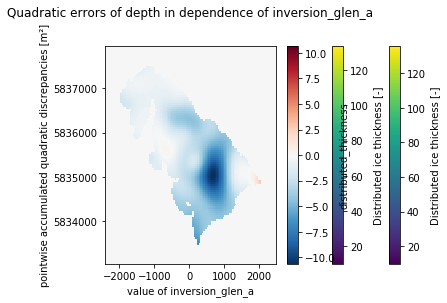

2019-11-23 14:16:18: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


Minimal value is 826607.2190763424 at inversion_glen_a = 3.81e-24
obs grid cells count: 483
dfb exponent:         0.25
smoothing window (m): 47.0
smoothing radius (m): 47.0


2019-11-23 14:16:19: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-11-23 14:16:19: oggm.workflow: Multiprocessing: using all available processors (N=8)
2019-11-23 14:16:19: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-11-23 14:16:19: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-11-23 14:16:20: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-11-23 14:16:20: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-11-23 14:16:20: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-11-23 14:16:20: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-11-23 14:16:20: oggm.workflow: Execute entity task catchment_width_geom on 1 glaciers
2019-11-23 14:16:21

slope: 0.363928    intercept: 2460.945896   R-squared: 0.995941


2019-11-23 14:16:22: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-11-23 14:16:22: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2333.9206261155123, 'grad': 7.92}
slope default: 0.363928    intercept: 2460.945896   R-squared: 0.995941
slope: 0.126263    intercept: 2333.920626   R-squared: 1.000000
parameter value: 3.81e-24

glacier total volume: rgi_id
RGI60-02.07780    0.395619
Name: inv_volume_km3, dtype: float64 km^3 
 
 

mean thickness value: 64.05931353375314 m 

<oggm.GlacierDirectory>
  RGI id: RGI60-02.07780
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 6.485 km2
  Lon, Lat: (-119.580934267502, 52.67048480925819)
  Grid (nx, ny): (107, 107)
  Grid (dx, dy): (46.0, -46.0)



2019-11-23 14:16:22: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg
2019-11-23 14:16:23: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-11-23 14:16:23: oggm.workflow: Multiprocessing: using all available processors (N=8)
2019-11-23 14:16:24: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-11-23 14:16:24: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-11-23 14:16:24: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-11-23 14:16:24: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-11-23 14:16:24: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-11-23 14:16:24: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instea

slope: 0.363928    intercept: 2460.945896   R-squared: 0.995941


2019-11-23 14:16:26: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-11-23 14:16:26: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers
2019-11-23 14:16:26: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


{'ela_h': 2333.9206261155123, 'grad': 7.92}
slope default: 0.363928    intercept: 2460.945896   R-squared: 0.995941
slope: 0.126263    intercept: 2333.920626   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.07780
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 6.485 km2
  Lon, Lat: (-119.580934267502, 52.67048480925819)
  Grid (nx, ny): (107, 107)
  Grid (dx, dy): (46.0, -46.0)



2019-11-23 14:16:27: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg
2019-11-23 14:16:27: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers


/home/pelto/Desktop/lidar_cbt_analysis/zillmer/160914_zillmer_dem2.tif


2019-11-23 14:16:28: oggm.workflow: Multiprocessing: using all available processors (N=8)
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-11-23 14:16:29: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-11-23 14:16:29: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-11-23 14:16:29: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-11-23 14:16:29: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-11-23 14:16:29: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-11-23 14:16:29: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-11-23 14:16:30: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarn

slope: 0.364873    intercept: 2466.917308   R-squared: 0.998025


2019-11-23 14:16:32: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-11-23 14:16:32: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2336.325310361338, 'grad': 7.92}
slope default: 0.364873    intercept: 2466.917308   R-squared: 0.998025
slope: 0.126263    intercept: 2336.325310   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.07780
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 6.485 km2
  Lon, Lat: (-119.580934267502, 52.67048480925819)
  Grid (nx, ny): (107, 107)
  Grid (dx, dy): (46.0, -46.0)



2019-11-23 14:16:32: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


Fantanstic, both arrays have the same shape of:  (88, 88)


2019-11-23 14:16:34: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg
2019-11-23 14:16:34: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers


/home/pelto/Desktop/lidar_cbt_analysis/zillmer/160914_zillmer_dem2.tif


2019-11-23 14:16:34: oggm.workflow: Multiprocessing: using all available processors (N=8)
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-11-23 14:16:35: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-11-23 14:16:36: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-11-23 14:16:36: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-11-23 14:16:36: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-11-23 14:16:36: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-11-23 14:16:36: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-11-23 14:16:36: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarn

slope: 0.364873    intercept: 2466.917308   R-squared: 0.998025


2019-11-23 14:16:38: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-11-23 14:16:38: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2336.325310361338, 'grad': 7.92}
slope default: 0.364873    intercept: 2466.917308   R-squared: 0.998025
slope: 0.126263    intercept: 2336.325310   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.07780
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 6.485 km2
  Lon, Lat: (-119.580934267502, 52.67048480925819)
  Grid (nx, ny): (107, 107)
  Grid (dx, dy): (46.0, -46.0)

found  1  problem(s) within a total number of data point of:  483  problem share  0.009813377664937015
corrected quadratic error is:  867264.7509715077


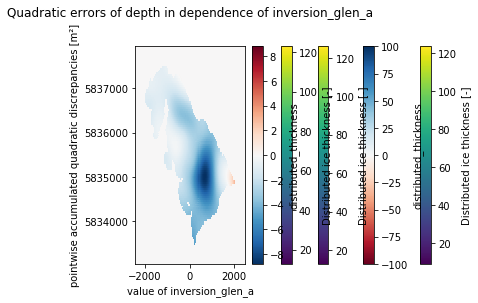

2019-11-23 14:16:39: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


Minimal value is 867264.7509715077 at inversion_glen_a = 3.81e-24
obs grid cells count: 483
dfb exponent:         0.25
smoothing window (m): 71.0
smoothing radius (m): 71.0


2019-11-23 14:16:40: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-11-23 14:16:40: oggm.workflow: Multiprocessing: using all available processors (N=8)
2019-11-23 14:16:40: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-11-23 14:16:40: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-11-23 14:16:40: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-11-23 14:16:40: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-11-23 14:16:40: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-11-23 14:16:41: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-11-23 14:16:41: oggm.workflow: Execute entity task catchment_width_geom on 1 glaciers
2019-11-23 14:16:41

slope: 0.363928    intercept: 2460.945896   R-squared: 0.995941


2019-11-23 14:16:42: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-11-23 14:16:42: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2333.9206261155123, 'grad': 7.92}
slope default: 0.363928    intercept: 2460.945896   R-squared: 0.995941
slope: 0.126263    intercept: 2333.920626   R-squared: 1.000000
parameter value: 3.81e-24

glacier total volume: rgi_id
RGI60-02.07780    0.395619
Name: inv_volume_km3, dtype: float64 km^3 
 
 

mean thickness value: 64.05931353375314 m 

<oggm.GlacierDirectory>
  RGI id: RGI60-02.07780
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 6.485 km2
  Lon, Lat: (-119.580934267502, 52.67048480925819)
  Grid (nx, ny): (107, 107)
  Grid (dx, dy): (46.0, -46.0)



2019-11-23 14:16:43: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg
2019-11-23 14:16:44: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-11-23 14:16:44: oggm.workflow: Multiprocessing: using all available processors (N=8)
2019-11-23 14:16:44: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-11-23 14:16:44: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-11-23 14:16:44: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-11-23 14:16:44: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-11-23 14:16:44: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-11-23 14:16:45: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instea

slope: 0.363928    intercept: 2460.945896   R-squared: 0.995941


2019-11-23 14:16:47: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-11-23 14:16:47: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers
2019-11-23 14:16:47: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


{'ela_h': 2333.9206261155123, 'grad': 7.92}
slope default: 0.363928    intercept: 2460.945896   R-squared: 0.995941
slope: 0.126263    intercept: 2333.920626   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.07780
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 6.485 km2
  Lon, Lat: (-119.580934267502, 52.67048480925819)
  Grid (nx, ny): (107, 107)
  Grid (dx, dy): (46.0, -46.0)



2019-11-23 14:16:48: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg
2019-11-23 14:16:48: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers


/home/pelto/Desktop/lidar_cbt_analysis/zillmer/160914_zillmer_dem2.tif


2019-11-23 14:16:48: oggm.workflow: Multiprocessing: using all available processors (N=8)
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-11-23 14:16:50: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-11-23 14:16:50: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-11-23 14:16:50: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-11-23 14:16:50: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-11-23 14:16:50: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-11-23 14:16:50: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-11-23 14:16:51: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarn

slope: 0.364873    intercept: 2466.917308   R-squared: 0.998025


2019-11-23 14:16:53: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-11-23 14:16:53: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2336.325310361338, 'grad': 7.92}
slope default: 0.364873    intercept: 2466.917308   R-squared: 0.998025
slope: 0.126263    intercept: 2336.325310   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.07780
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 6.485 km2
  Lon, Lat: (-119.580934267502, 52.67048480925819)
  Grid (nx, ny): (107, 107)
  Grid (dx, dy): (46.0, -46.0)



2019-11-23 14:16:53: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


Fantanstic, both arrays have the same shape of:  (88, 88)


2019-11-23 14:16:54: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg
2019-11-23 14:16:54: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers


/home/pelto/Desktop/lidar_cbt_analysis/zillmer/160914_zillmer_dem2.tif


2019-11-23 14:16:54: oggm.workflow: Multiprocessing: using all available processors (N=8)
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-11-23 14:16:56: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-11-23 14:16:56: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-11-23 14:16:56: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-11-23 14:16:56: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-11-23 14:16:56: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-11-23 14:16:56: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-11-23 14:16:57: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarn

slope: 0.364873    intercept: 2466.917308   R-squared: 0.998025


2019-11-23 14:16:59: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-11-23 14:16:59: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2336.325310361338, 'grad': 7.92}
slope default: 0.364873    intercept: 2466.917308   R-squared: 0.998025
slope: 0.126263    intercept: 2336.325310   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.07780
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 6.485 km2
  Lon, Lat: (-119.580934267502, 52.67048480925819)
  Grid (nx, ny): (107, 107)
  Grid (dx, dy): (46.0, -46.0)

found  1  problem(s) within a total number of data point of:  483  problem share  0.009458449054842954
corrected quadratic error is:  900131.4221701475


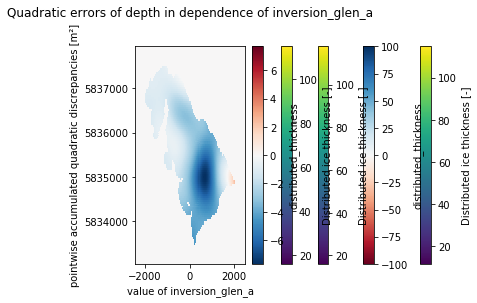

2019-11-23 14:16:59: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


Minimal value is 900131.4221701475 at inversion_glen_a = 3.81e-24
obs grid cells count: 483
dfb exponent:         0.25
smoothing window (m): 101.0
smoothing radius (m): 101.0


2019-11-23 14:17:00: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-11-23 14:17:00: oggm.workflow: Multiprocessing: using all available processors (N=8)
2019-11-23 14:17:01: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-11-23 14:17:01: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-11-23 14:17:01: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-11-23 14:17:01: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-11-23 14:17:01: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-11-23 14:17:01: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-11-23 14:17:01: oggm.workflow: Execute entity task catchment_width_geom on 1 glaciers
2019-11-23 14:17:02

slope: 0.363928    intercept: 2460.945896   R-squared: 0.995941


2019-11-23 14:17:03: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-11-23 14:17:03: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2333.9206261155123, 'grad': 7.92}
slope default: 0.363928    intercept: 2460.945896   R-squared: 0.995941
slope: 0.126263    intercept: 2333.920626   R-squared: 1.000000
parameter value: 3.81e-24

glacier total volume: rgi_id
RGI60-02.07780    0.395619
Name: inv_volume_km3, dtype: float64 km^3 
 
 

mean thickness value: 64.05931353375314 m 

<oggm.GlacierDirectory>
  RGI id: RGI60-02.07780
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 6.485 km2
  Lon, Lat: (-119.580934267502, 52.67048480925819)
  Grid (nx, ny): (107, 107)
  Grid (dx, dy): (46.0, -46.0)



2019-11-23 14:17:03: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg
2019-11-23 14:17:05: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-11-23 14:17:05: oggm.workflow: Multiprocessing: using all available processors (N=8)
2019-11-23 14:17:05: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-11-23 14:17:05: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-11-23 14:17:05: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-11-23 14:17:05: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-11-23 14:17:05: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-11-23 14:17:05: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instea

slope: 0.363928    intercept: 2460.945896   R-squared: 0.995941


2019-11-23 14:17:07: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-11-23 14:17:07: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers
2019-11-23 14:17:07: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


{'ela_h': 2333.9206261155123, 'grad': 7.92}
slope default: 0.363928    intercept: 2460.945896   R-squared: 0.995941
slope: 0.126263    intercept: 2333.920626   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.07780
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 6.485 km2
  Lon, Lat: (-119.580934267502, 52.67048480925819)
  Grid (nx, ny): (107, 107)
  Grid (dx, dy): (46.0, -46.0)



2019-11-23 14:17:08: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg
2019-11-23 14:17:09: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers


/home/pelto/Desktop/lidar_cbt_analysis/zillmer/160914_zillmer_dem2.tif


2019-11-23 14:17:09: oggm.workflow: Multiprocessing: using all available processors (N=8)
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-11-23 14:17:10: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-11-23 14:17:10: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-11-23 14:17:10: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-11-23 14:17:10: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-11-23 14:17:10: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-11-23 14:17:11: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-11-23 14:17:11: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarn

slope: 0.363620    intercept: 2468.614991   R-squared: 0.996879


2019-11-23 14:17:13: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-11-23 14:17:13: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2339.645530939786, 'grad': 7.92}
slope default: 0.363620    intercept: 2468.614991   R-squared: 0.996879
slope: 0.126263    intercept: 2339.645531   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.07780
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 6.485 km2
  Lon, Lat: (-119.580934267502, 52.67048480925819)
  Grid (nx, ny): (107, 107)
  Grid (dx, dy): (46.0, -46.0)



2019-11-23 14:17:14: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


Fantanstic, both arrays have the same shape of:  (88, 88)


2019-11-23 14:17:15: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg
2019-11-23 14:17:15: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers


/home/pelto/Desktop/lidar_cbt_analysis/zillmer/160914_zillmer_dem2.tif


2019-11-23 14:17:15: oggm.workflow: Multiprocessing: using all available processors (N=8)
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-11-23 14:17:17: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-11-23 14:17:17: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-11-23 14:17:17: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-11-23 14:17:17: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-11-23 14:17:17: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-11-23 14:17:17: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-11-23 14:17:18: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarn

slope: 0.363620    intercept: 2468.614991   R-squared: 0.996879


2019-11-23 14:17:20: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-11-23 14:17:20: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2339.645530939786, 'grad': 7.92}
slope default: 0.363620    intercept: 2468.614991   R-squared: 0.996879
slope: 0.126263    intercept: 2339.645531   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.07780
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 6.485 km2
  Lon, Lat: (-119.580934267502, 52.67048480925819)
  Grid (nx, ny): (107, 107)
  Grid (dx, dy): (46.0, -46.0)

found  1  problem(s) within a total number of data point of:  483  problem share  0.009213921777598534
corrected quadratic error is:  924248.0185914941


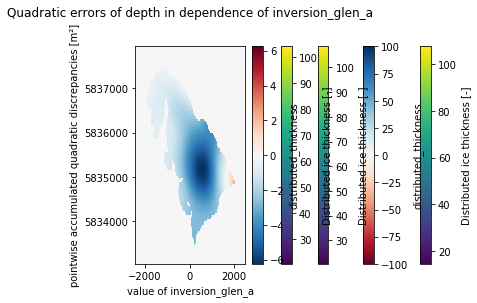

2019-11-23 14:17:20: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


Minimal value is 924248.0185914941 at inversion_glen_a = 3.81e-24
obs grid cells count: 483
dfb exponent:         0.25
smoothing window (m): 151.0
smoothing radius (m): 151.0


2019-11-23 14:17:21: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-11-23 14:17:21: oggm.workflow: Multiprocessing: using all available processors (N=8)
2019-11-23 14:17:21: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-11-23 14:17:21: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-11-23 14:17:21: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-11-23 14:17:21: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-11-23 14:17:22: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-11-23 14:17:22: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-11-23 14:17:22: oggm.workflow: Execute entity task catchment_width_geom on 1 glaciers
2019-11-23 14:17:22

slope: 0.363928    intercept: 2460.945896   R-squared: 0.995941


2019-11-23 14:17:24: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-11-23 14:17:24: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2333.9206261155123, 'grad': 7.92}
slope default: 0.363928    intercept: 2460.945896   R-squared: 0.995941
slope: 0.126263    intercept: 2333.920626   R-squared: 1.000000
parameter value: 3.81e-24

glacier total volume: rgi_id
RGI60-02.07780    0.395619
Name: inv_volume_km3, dtype: float64 km^3 
 
 

mean thickness value: 64.05931353375314 m 

<oggm.GlacierDirectory>
  RGI id: RGI60-02.07780
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 6.485 km2
  Lon, Lat: (-119.580934267502, 52.67048480925819)
  Grid (nx, ny): (107, 107)
  Grid (dx, dy): (46.0, -46.0)



2019-11-23 14:17:24: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg
2019-11-23 14:17:25: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-11-23 14:17:25: oggm.workflow: Multiprocessing: using all available processors (N=8)
2019-11-23 14:17:25: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-11-23 14:17:26: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-11-23 14:17:26: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-11-23 14:17:26: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-11-23 14:17:26: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-11-23 14:17:26: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instea

slope: 0.363928    intercept: 2460.945896   R-squared: 0.995941


2019-11-23 14:17:28: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-11-23 14:17:28: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers
2019-11-23 14:17:28: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


{'ela_h': 2333.9206261155123, 'grad': 7.92}
slope default: 0.363928    intercept: 2460.945896   R-squared: 0.995941
slope: 0.126263    intercept: 2333.920626   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.07780
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 6.485 km2
  Lon, Lat: (-119.580934267502, 52.67048480925819)
  Grid (nx, ny): (107, 107)
  Grid (dx, dy): (46.0, -46.0)



2019-11-23 14:17:29: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg
2019-11-23 14:17:29: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers


/home/pelto/Desktop/lidar_cbt_analysis/zillmer/160914_zillmer_dem2.tif


2019-11-23 14:17:30: oggm.workflow: Multiprocessing: using all available processors (N=8)
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-11-23 14:17:31: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-11-23 14:17:31: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-11-23 14:17:31: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-11-23 14:17:31: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-11-23 14:17:31: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-11-23 14:17:32: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-11-23 14:17:32: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarn

slope: 0.364281    intercept: 2468.194754   R-squared: 0.998050


2019-11-23 14:17:34: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-11-23 14:17:34: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2337.7084506392607, 'grad': 7.92}
slope default: 0.364281    intercept: 2468.194754   R-squared: 0.998050
slope: 0.126263    intercept: 2337.708451   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.07780
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 6.485 km2
  Lon, Lat: (-119.580934267502, 52.67048480925819)
  Grid (nx, ny): (107, 107)
  Grid (dx, dy): (46.0, -46.0)



2019-11-23 14:17:35: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


Fantanstic, both arrays have the same shape of:  (88, 88)


2019-11-23 14:17:36: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg
2019-11-23 14:17:36: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers


/home/pelto/Desktop/lidar_cbt_analysis/zillmer/160914_zillmer_dem2.tif


2019-11-23 14:17:36: oggm.workflow: Multiprocessing: using all available processors (N=8)
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-11-23 14:17:37: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-11-23 14:17:38: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-11-23 14:17:38: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-11-23 14:17:38: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-11-23 14:17:38: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-11-23 14:17:38: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-11-23 14:17:39: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarn

slope: 0.364281    intercept: 2468.194754   R-squared: 0.998050


2019-11-23 14:17:40: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-11-23 14:17:40: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2337.7084506392607, 'grad': 7.92}
slope default: 0.364281    intercept: 2468.194754   R-squared: 0.998050
slope: 0.126263    intercept: 2337.708451   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.07780
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 6.485 km2
  Lon, Lat: (-119.580934267502, 52.67048480925819)
  Grid (nx, ny): (107, 107)
  Grid (dx, dy): (46.0, -46.0)

found  1  problem(s) within a total number of data point of:  483  problem share  0.00881264915195039
corrected quadratic error is:  966723.8301991955


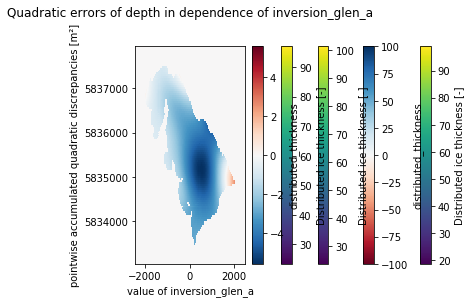

2019-11-23 14:17:41: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


Minimal value is 966723.8301991955 at inversion_glen_a = 3.81e-24
obs grid cells count: 483
dfb exponent:         0.25
smoothing window (m): 201.0
smoothing radius (m): 201.0


2019-11-23 14:17:42: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-11-23 14:17:42: oggm.workflow: Multiprocessing: using all available processors (N=8)
2019-11-23 14:17:42: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-11-23 14:17:42: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-11-23 14:17:42: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-11-23 14:17:42: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-11-23 14:17:42: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-11-23 14:17:43: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-11-23 14:17:43: oggm.workflow: Execute entity task catchment_width_geom on 1 glaciers
2019-11-23 14:17:43

slope: 0.363928    intercept: 2460.945896   R-squared: 0.995941


2019-11-23 14:17:45: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-11-23 14:17:45: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2333.9206261155123, 'grad': 7.92}
slope default: 0.363928    intercept: 2460.945896   R-squared: 0.995941
slope: 0.126263    intercept: 2333.920626   R-squared: 1.000000
parameter value: 3.81e-24

glacier total volume: rgi_id
RGI60-02.07780    0.395619
Name: inv_volume_km3, dtype: float64 km^3 
 
 

mean thickness value: 64.05931353375314 m 

<oggm.GlacierDirectory>
  RGI id: RGI60-02.07780
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 6.485 km2
  Lon, Lat: (-119.580934267502, 52.67048480925819)
  Grid (nx, ny): (107, 107)
  Grid (dx, dy): (46.0, -46.0)



2019-11-23 14:17:45: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg
2019-11-23 14:17:46: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-11-23 14:17:47: oggm.workflow: Multiprocessing: using all available processors (N=8)
2019-11-23 14:17:47: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-11-23 14:17:47: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-11-23 14:17:47: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-11-23 14:17:47: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-11-23 14:17:47: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-11-23 14:17:47: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instea

slope: 0.363928    intercept: 2460.945896   R-squared: 0.995941


2019-11-23 14:17:49: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-11-23 14:17:49: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers
2019-11-23 14:17:50: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


{'ela_h': 2333.9206261155123, 'grad': 7.92}
slope default: 0.363928    intercept: 2460.945896   R-squared: 0.995941
slope: 0.126263    intercept: 2333.920626   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.07780
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 6.485 km2
  Lon, Lat: (-119.580934267502, 52.67048480925819)
  Grid (nx, ny): (107, 107)
  Grid (dx, dy): (46.0, -46.0)



2019-11-23 14:17:51: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg
2019-11-23 14:17:51: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers


/home/pelto/Desktop/lidar_cbt_analysis/zillmer/160914_zillmer_dem2.tif


2019-11-23 14:17:51: oggm.workflow: Multiprocessing: using all available processors (N=8)
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-11-23 14:17:52: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-11-23 14:17:53: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-11-23 14:17:53: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-11-23 14:17:53: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-11-23 14:17:53: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-11-23 14:17:53: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-11-23 14:17:53: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarn

slope: 0.364058    intercept: 2468.129063   R-squared: 0.998027


2019-11-23 14:17:55: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-11-23 14:17:55: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2337.6770859726303, 'grad': 7.92}
slope default: 0.364058    intercept: 2468.129063   R-squared: 0.998027
slope: 0.126263    intercept: 2337.677086   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.07780
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 6.485 km2
  Lon, Lat: (-119.580934267502, 52.67048480925819)
  Grid (nx, ny): (107, 107)
  Grid (dx, dy): (46.0, -46.0)



2019-11-23 14:17:56: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


Fantanstic, both arrays have the same shape of:  (88, 88)


2019-11-23 14:17:57: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg
2019-11-23 14:17:57: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers


/home/pelto/Desktop/lidar_cbt_analysis/zillmer/160914_zillmer_dem2.tif


2019-11-23 14:17:57: oggm.workflow: Multiprocessing: using all available processors (N=8)
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-11-23 14:17:59: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-11-23 14:17:59: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-11-23 14:17:59: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-11-23 14:17:59: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-11-23 14:17:59: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-11-23 14:17:59: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-11-23 14:18:00: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarn

slope: 0.364058    intercept: 2468.129063   R-squared: 0.998027


2019-11-23 14:18:02: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-11-23 14:18:02: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2337.6770859726303, 'grad': 7.92}
slope default: 0.364058    intercept: 2468.129063   R-squared: 0.998027
slope: 0.126263    intercept: 2337.677086   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.07780
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 6.485 km2
  Lon, Lat: (-119.580934267502, 52.67048480925819)
  Grid (nx, ny): (107, 107)
  Grid (dx, dy): (46.0, -46.0)

found  1  problem(s) within a total number of data point of:  483  problem share  0.008548368121659912
corrected quadratic error is:  996876.7552576838


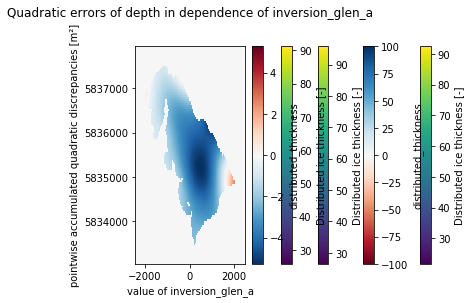

2019-11-23 14:18:02: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


Minimal value is 996876.7552576838 at inversion_glen_a = 3.81e-24
obs grid cells count: 483
dfb exponent:         0.25
smoothing window (m): 251.0
smoothing radius (m): 251.0


2019-11-23 14:18:04: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-11-23 14:18:04: oggm.workflow: Multiprocessing: using all available processors (N=8)
2019-11-23 14:18:04: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-11-23 14:18:04: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-11-23 14:18:04: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-11-23 14:18:04: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-11-23 14:18:04: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-11-23 14:18:05: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-11-23 14:18:05: oggm.workflow: Execute entity task catchment_width_geom on 1 glaciers
2019-11-23 14:18:05

slope: 0.363928    intercept: 2460.945896   R-squared: 0.995941


2019-11-23 14:18:06: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-11-23 14:18:06: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2333.9206261155123, 'grad': 7.92}
slope default: 0.363928    intercept: 2460.945896   R-squared: 0.995941
slope: 0.126263    intercept: 2333.920626   R-squared: 1.000000
parameter value: 3.81e-24

glacier total volume: rgi_id
RGI60-02.07780    0.395619
Name: inv_volume_km3, dtype: float64 km^3 
 
 

mean thickness value: 64.05931353375314 m 

<oggm.GlacierDirectory>
  RGI id: RGI60-02.07780
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 6.485 km2
  Lon, Lat: (-119.580934267502, 52.67048480925819)
  Grid (nx, ny): (107, 107)
  Grid (dx, dy): (46.0, -46.0)



[826607.2190763424,
 867264.7509715077,
 900131.4221701475,
 924248.0185914941,
 966723.8301991955,
 996876.7552576838]

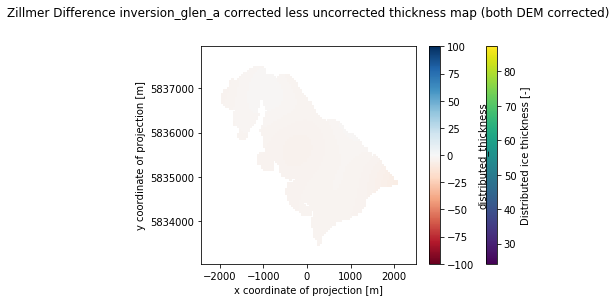

In [14]:
for i in sr:
    SR=sr[count]
    sw=sr[count]
    def new_mb_grad_corr_dem(num, dem, glacier, name, parameter, best, use_dem_corr):
        """
        :param num: number of selected glacier
        :param dem: list with dem file names
        :param glacier: the list with the glacier names
        :param name: name of the parameter to be modified
        :param parameter: value of the parameter to be modified
        :param best: if TRUE, an extra save with prefix 'best' will be created
        :param use_dem_correction: if TRUE, a Lidar DEM correction will be used
        :type num: int
        :type dem: str list
        :type glacier: str list
        :type name: str 
        :type parameter: float
        :type best: boolean
        :type use_dem_correction: boolean
        :returns: distributed thickness
        :rtype: 2D float array
        """
        # Initialize OGGM and set up the run parameters --> Read the configuration file containing the run’s parameters.
        cfg.initialize(logging_level='WORKFLOW')

        #num determines which gdir and gradient to use, refer to list below to select desired site
        grad = [6.84, 9.8, 7.11, 7.95, 10.84, 6.01, 7.92] # mm w.e. m-1


        # Get the RGI glaciers for the run.
        rgi_list = ['RGI60-02.00147', 'RGI60-02.01857', 'RGI60-02.02171', 'RGI60-02.03411', 'RGI60-02.03688', 'RGI60-02.04264', 'RGI60-02.07780']
        temporarily = [rgi_list[num]]
        rgidf = utils.get_rgi_glacier_entities(temporarily)#[rgi_list[num]]) !!!!!!!!!


        ############################################################# here the DEM correction happens #########################################################

        if(use_dem_corr==True):

            custom_dem_path = '/home/pelto/Desktop/lidar_cbt_analysis/' + dem[num] #glacier_lower[num]
            print(custom_dem_path)
            WORKING_DIR2 = utils.gettempdir(glacier[num] + '_SR_lidar_dem') # Let's make a working directory for this DEM 
            utils.mkdir(WORKING_DIR2, reset=True)
            cfg.initialize(logging_level='WORKFLOW')
            cfg.PATHS['working_dir'] = WORKING_DIR2

            cfg.PATHS['dem_file'] = custom_dem_path
            rgidf['DEM_SOURCE'] = 'USER'
            cfg.PARAMS['use_intersects'] = True

            cfg.PARAMS['smooth_window'] = sw
    #         cfg.PARAMS['grid_dx_method'] = 'fixed'
    #         cfg.PARAMS['fixed_dx'] = dx[num]
            if glacier[num] == 'Nordic' or 'Washmawapta':
                cfg.PARAMS['use_intersects'] = False

    #         gdirs = workflow.init_glacier_regions(rgidf)
            cfg.PARAMS['use_rgi_area'] = False

        else:
            cfg.PARAMS['use_intersects'] = True
            if glacier[num] == 'Nordic' or 'Washmawapta':
                cfg.PARAMS['use_intersects'] = False
            cfg.PARAMS['border'] = 10
            cfg.PATHS['working_dir'] = utils.get_temp_dir('_SR_thick_srtm' + glacier[num])
            cfg.PARAMS['use_rgi_area'] = False
            cfg.PARAMS[name] = parameter
            cfg.PARAMS['smooth_window'] = sw

        ###########################################################################################################################

        cfg.PARAMS[name] = parameter
        cfg.PARAMS['border'] = 10

        gdirs = workflow.init_glacier_regions(rgidf)
        workflow.gis_prepro_tasks(gdirs)
        workflow.climate_tasks(gdirs)
        workflow.inversion_tasks(gdirs)
        workflow.execute_entity_task(tasks.distribute_thickness_per_altitude, gdirs, smooth_radius=SR, dis_from_border_exp=dfb);

        gdir = gdirs[0]
        tasks.init_present_time_glacier(gdir) ##This updates the mode_flowlines file and creates a stand-alone numerical glacier ready to run.

        # Print the standard MB gradient from OGGM default
        from oggm.core.massbalance import ConstantMassBalance, MultipleFlowlineMassBalance
        # gdir = gdirs[num]

        mb_mod = MultipleFlowlineMassBalance(gdir, use_inversion_flowlines=True, mb_model_class=ConstantMassBalance)
        z, w, mb_on_z = mb_mod.get_annual_mb_on_flowlines()
        mb_on_z *=  cfg.PARAMS['ice_density'] * cfg.SEC_IN_YEAR

        # grad_line = np.polyfit(mb_on_z,z,2)
        from scipy import stats 
        slope, intercept, r_value, p_value, std_err = stats.linregress(mb_on_z, z)
        print("slope: %f    intercept: %f" % (slope, intercept), "  R-squared: %f" % r_value**2)

        # See the result of the inversion
        workflow.execute_entity_task(tasks.distribute_thickness_per_altitude, gdirs, smooth_radius=SR, dis_from_border_exp=dfb);

        ds_default = xr.open_dataset(gdir.get_filepath('gridded_data')).load()
        ds_default.close() # I have the strange feeling that xarray sometimes won't re-read overwitten files (and we will overwrite it later)

        ds_default = xr.open_dataset(gdir.get_filepath('gridded_data')).load()
        ds_default.close() # I have the strange feeling that xarray sometimes won't re-read overwitten files (and we will overwrite it later)


        # Let's apply a linear MB instead
        from oggm.core.climate import apparent_mb_from_linear_mb


        workflow.execute_entity_task(tasks.apparent_mb_from_linear_mb, gdir, mb_gradient=grad[num]);

        from oggm.core.massbalance import LinearMassBalance

        params = gdir.read_pickle('linear_mb_params')
        print(params)

        l_mb_mod = LinearMassBalance(params['ela_h'], grad=params['grad'])
        l_mb_on_z = l_mb_mod.get_annual_mb(z) * cfg.PARAMS['ice_density'] * cfg.SEC_IN_YEAR

        slope, intercept, r_value, p_value, std_err = stats.linregress(mb_on_z, z)
        print("slope default: %f    intercept: %f" % (slope, intercept), "  R-squared: %f" % r_value**2)
        slope, intercept, r_value, p_value, std_err = stats.linregress(l_mb_on_z, z)
        print("slope: %f    intercept: %f" % (slope, intercept), "  R-squared: %f" % r_value**2)

        ds_new = xr.open_dataset(gdir.get_filepath('gridded_data')).load()
        ds_new.close() 


        ########### gather more detailed information about the glacier ##############
        df  = utils.compile_glacier_statistics(gdirs, inversion_only=True)
        volume=df['inv_volume_km3']

        mfl=gdir.read_pickle('model_flowlines')
        thickness= mfl[-1].surface_h - mfl[-1].bed_h
        thickness=thickness[thickness>0].mean()

        ############## write it into txt file: #################

        if(best):
            file= open(products+'best_dem_corr_run_of_'+glacier[num]+'_with_modified_' + name + '.txt', mode='w')
            print('parameter value: '+str(parameter)+'\n')
            print('glacier total volume: '+str(volume)+' km^3 \n \n \n')
            print('mean thickness value: '+str(thickness)+' m \n')
        else:
            file= open(products+'dem_corr_run_of_'+glacier[num]+'_with_modified_' + name+'.txt', mode='w')

        file.writelines(['Run of the DEM corrected model on ' + glacier[num]+' on ', str(datetime.datetime.now()), '\n'])
        file.write('parameter modified: '+name+'\n')
        file.write('parameter value: '+str(parameter)+'\n')
        file.write('glacier total volume: '+str(volume)+' km^3 \n \n \n')
        file.write('mean thickness value: '+str(thickness)+' m \n')
    #     file.write('Minimal value is '+str(np.min(to_plot[1]))+ ' at ' + parameter_name+' = ' +str(np.round(to_plot[0][x],decimals=28)))
        file.close()
        ##########################################################
        print(gdir)
        return ds_new.distributed_thickness

    ## Comparing DEM-corrected model with non-DEM-corrected model:

#     - first we run the 'new_mb_grad' function
#     - then we run the 'new_mb_grad_corr_dem' function
#     - and then we subtract the thickness maps and can see where the usage of Lidar data actually impacted the outcome of the model

    # run the model without DEM correction
    new_mb_gradient= new_mb_grad_corr_dem(num, dem, glacier, 'ice_density', 900, False, False)

    # plot it as a map
    new_mb_gradient.plot()
    plt.title(glacier[num]+' standard settings thickness map')
    # and save it
    plt.savefig('/home/pelto/Desktop/ice_thick/products'+'standard_map_'+ glacier[num]+'.png', dpi=100)

    # replace 'nan' by  0
    new_mb_gradient=new_mb_gradient.fillna(0)

    if glacier[num]=='Washmawapta':
        # make a copy for comparison reasons later on
        new_mb_gradient_corr_dem=new_mb_gradient

    # run the model with DEM correction
    new_mb_gradient_corr_dem = new_mb_grad_corr_dem(num, dem, glacier, 'ice_density', 900, False, True)

    # plot it as a map
    new_mb_gradient_corr_dem.plot()
    plt.title(glacier[num]+' DEM corrected Thickness map')

    # and save it
    plt.savefig(products+'dem_corr_standard_map_'+ glacier[num]+'.png', dpi=100)

    # replace 'nan' by  0
    new_mb_gradient_corr_dem=new_mb_gradient_corr_dem.fillna(0)

    # make a copy for comparison reasons later on
    new_mb_gradient_corr_dem_copy=new_mb_gradient_corr_dem

    # the actual differencing and plotting
    (new_mb_gradient_corr_dem-new_mb_gradient).plot()

    # label it, save it
    plt.title(glacier[num]+' Difference DEM corrected tickness less standard DEM')
    plt.savefig(products+'difference_dem_correction_'+ glacier[num]+'.png', dpi=100)

    ## Parameter optimization

#     We want to run the Model with different values for a certain parameter. Therefore we define a few functions that will iterate over a sequenze of paramter values and allow us to compare the outcome to the observation data by displaying their respective squared residuals

    def run_with_parameter(num,dem, glacier, name, parameter):
        """
        :param num: number of selected glacier
        :param dem: list with dem file names
        :param glacier: the list with the glacier names
        :param name: name of the parameter to be modified
        :param parameter: value of the parameter to be modified
        :type num: int
        :type dem: str list
        :type glacier: str list
        :type name: str 
        :type parameter: float
        :returns: distributed thickness
        :rtype: 2D float array
        """

        # just to be 100% sure, we are setting the most common parameters to their presettings in order to only vary the desired parameter
        cfg.PARAMS['smooth_window'] = sw
        cfg.PARAMS['ice_density'] = 900
        cfg.PARAMS['trapezoid_lambdas'] = 0.2
        cfg.PARAMS['mixed_min_shape'] = 0.001
        cfg.PARAMS['downstream_min_shape'] = 0.0001
        cfg.PARAMS['mu_star_halfperiod'] = 15
        cfg.PARAMS['tstar_search_glacierwide'] = False
        cfg.PARAMS['border'] = 10
        cfg.PARAMS['glen_a'] = 2.4e-24
        cfg.PARAMS['inversion_glen_a'] = 2.4e-24
        cfg.PARAMS['default_parabolic_bedshape'] = 0.003
        cfg.PARAMS['use_shape_factor_for_fluxbasedmodel'] = ''

        #change the parameter (not sure, whether it has any effect here...)
        cfg.PARAMS[name] = parameter

        # run the model (in this case with DEM correction)
        outcome=new_mb_grad_corr_dem(num, dem, glacier, name, parameter, False, True).fillna(0)

        #return the thickness distribution
        return outcome

    ## Definitions


    # deletes the rows and lines that do only carry zeros for the sake of getting the right resolution 
    # in order to rasterize the observation data to the same resolution and getting perfectly fitting arrays
    def delete_nodata(data):
        """
        :param data: distributed thickness with 'nan' or '0' in it
        :type data: 2D floar array
        :returns: distributed thickness
        :rtype: 2D float array
        """

        # get a numpy array out of it
        data=data.values

        #get the spots were actual values are
        coordinates=np.nonzero(data)

        # create a fresh array of the minimal shape to contain all non-zero values
        result=np.zeros(((1+np.max(coordinates[0])-np.min(coordinates[0])) ,(1+np.max(coordinates[1])-np.min(coordinates[1]))))

        # fill it with the values
        for i in range(0, len(coordinates[0])):
            result[coordinates[0][i]-np.min(coordinates[0])][coordinates[1][i]-np.min(coordinates[1])]=data[coordinates[0][i]][coordinates[1][i]]

        # flip it and rotate it by pi
        return np.flip(np.rot90(result,2))

    # a simple function to open the observation data and return it as an array
    def read_obs_data(path):
        """
        :param path: distributed thickness with 'nan' or '0' in it
        :type path: str
        :returns: measurement points as an array
        :rtype: 2D float array
        """
        src_obs = gdal.Open(path)
        return src_obs.ReadAsArray()

    ## Data Import

    # We open the observation data for the respective glacier and print out the shape and compare it with the shape of the OGGM:

    obs_data = read_obs_data('/home/pelto/oggm_runs/OGGM/MONSTER_project/MONSTER/obs_data_' + glacier[num] + '.tif')

    if obs_data.shape == delete_nodata(new_mb_gradient_corr_dem).shape:
        print('Fantanstic, both arrays have the same shape of: ' ,obs_data.shape )
    else:
        print('Uh, Oh! Something went wrong because the observation data has the shape ' ,obs_data.shape , ' and the OGGM out put has a shape of: ' ,delete_nodata(new_mb_gradient_corr_dem).shape )



    # Layover-Control

#     This is a checking tool for adjusting the orientation of the observation data with respect to the model shapefile (in order to make it fit, we had to flip and rotate it in the 'delete_nodata' function). The resolution is not great but is should give an optical feedback on the fit. 

    # run the delete_nodata function on one of the recent outputs and save it in a temporay variable
    temp=delete_nodata(new_mb_gradient_corr_dem)

    # get its shape
    h,w = temp.shape

    # create a new array with zeros and of same size
    data = np.zeros((h, w, 3), dtype=np.uint8)

    # and get the data point coordinates
    nonzero=np.nonzero(temp)

    # run through the OGGM output and write into the array as RED color code
    for i in range(0,len(nonzero[0])):
        data[nonzero[0][i]][nonzero[1][i]]= [temp[nonzero[0][i]][nonzero[1][i]], 0, 0]

    # run through the observation data and write into the array as GREEN color code
    for i in range(0,len(np.nonzero(obs_data)[0])):
        data[np.nonzero(obs_data)[0][i]][np.nonzero(obs_data)[1][i]]= [0, obs_data[np.nonzero(obs_data)[0][i]][np.nonzero(obs_data)[1][i]], 0]

    # save and show
    img = imagery.fromarray(data, 'RGB')
    img.save(products+ 'overlay_test_'+ glacier[num]+ '.png')

    from IPython.display import Image
    Image(filename=products+'overlay_test_'+ glacier[num]+ '.png', width=400) 

    ## Quadratic Error


#     We want a function that gives us the accumulated quadratic residuals of the observation data compared to the OGGM output. Because we may have very few points that are assigned a measurement but do not locate on the OGGM glacier, we have to do a little extra: We count those pixels, print their share on the entire quadratic errors and subtract their errors from the result in order not to confuse the optimization process later on. However, their share usually is below 1-2% - their impact therefore limited. This is only done for checking and consistency reasons

    def quadratic_errors(obs_data, mesharray):
        """
        :param obs_data: array with measured values on respective spots
        :param mesharray: distributed thickness of the model output (should have same shape as obs_data)
        :type obs_data: 2D float array
        :type mesharray: 2D float array
        :returns: quadrativc error (problems corrected)
        :rtype: float
        """

        # counts number of "problematic" pixels
        count=0

        # coordinates of the data points
        coordinates=np.nonzero(obs_data)

        # accumulated 'problematic pixel' quadratic error
        problems=0

        # total accumulated quadratic error
        err=0

        # we go through all the measured points and accumulate the squared differences to the OGGM at that point
        for i in range(0,len(coordinates[0])):

            # if however, the OGGM shows a thickness of zero there, this seems to be a "problematic" pixel 
            if mesharray[coordinates[0][i]][coordinates[1][i]]==0:

                # add to problems share
                problems=problems+obs_data[coordinates[0][i]][coordinates[1][i]]**2

                # increment problem number
                count=count+1

            # add squared difference
            err=err+(obs_data[coordinates[0][i]][coordinates[1][i]]-mesharray[coordinates[0][i]][coordinates[1][i]])**2

        # outprint of details on "problematic" pixels
        print('found ', count , ' problem(s) within a total number of data point of: ', len(coordinates[0]), ' problem share ', problems/err,)

        print('corrected quadratic error is: ', err-problems)
        return (err-problems)

    # a function that runs the (DEM-corrected) OGGM and uses the quadratic_errors function to return the quadratic errors
    def master_analysis(name, parameter, obs_data, glacier, num):
        """
        :param name: name of the parameter to be modified
        :param parameter: value of the parameter to be modified
        :param obs_data: measured data points
        :param glacier: the list with the glacier names
        :param num: number of selected glacier
        :type name: str
        :type parameter: float
        :type obs_data: 2D float array
        :type glacier: str list
        :type num: int
        :returns: quadratic errors
        :rtype: float
        """
        quadmesh= run_with_parameter(num, dem, glacier, name, parameter)
        mesharray = delete_nodata(quadmesh)

        return quadratic_errors(obs_data, mesharray)

    # this function takes in the name of the parameter that is to be modified and a float list of the values for whose the OGGM is 
    # to be run and the quadratic errors to be calculated. It returns an array with those values and their respective quadratic errors
    def optimize(name, values, obs_data, glacier, num):
        """
        :param name: name of the parameter to be modified
        :param values: values of the parameter to be modified
        :param obs_data: measured data points
        :param glacier: the list with the glacier names
        :param num: number of selected glacier
        :type name: str
        :type values: float list
        :type obs_data: 2D float array
        :type glacier: str list
        :type num: int
        :returns: [values, quad_errors]
        :rtype: float array
        """

        # here we store the original parameter value
        temp= cfg.PARAMS[name]

        #an array to store the quadratic errors in
        quad_errors=[]
        for i in range(0,len(values)):
            quad_errors.append(master_analysis(name, values[i], obs_data, glacier, num))

        # and here we reset it to the default value
        cfg.PARAMS[name] = temp

        return [values, quad_errors]

    ## Enter the parameter, interval and number of points that you want to get the quadratic error from 

#     The parameter intervall will be a linearly spaced sequence from min_value to max_value with number_of_steps steps.

#     Also, choose, whether you prefer to run the iteration with the DEM correction. In the most cases it is strongly recommended to do so.
    

    
    parameter_name='inversion_glen_a'
    max_value= best_value
    min_value= best_value
    number_of_steps=1 #10

    use_dem_correction=True

    ## The actual iteration takes place here

#     %%capture supresses the output, which is quite annoying if the OGGM runs several dozen times. But if you want to watch it work, go for it and delete that line.

#     Apart from that, we basically run the optimize function

#     %%capture
    to_plot=optimize(parameter_name,np.linspace(min_value, max_value, number_of_steps), obs_data ,glacier, num)

#     Now, we plot the quadratic errors as a function of the parameter values. We also print out the minimum.

    from matplotlib import rcParams
    rcParams['axes.titlepad'] = 30
    plt.plot(to_plot[0],to_plot[1],linestyle='--', marker='o', color='b')
    plt.xlabel('value of '+parameter_name)
    plt.ylabel('pointwise accumulated quadratic discrepancies [m²]')
    plt.title('Quadratic errors of depth in dependence of ' +parameter_name)

    # save it
    plt.savefig(products+'quadratic_errors_'+parameter_name+'_from_'+str(min_value)+'_to_'+str(max_value)+'_'+ glacier[num]+'.png', dpi=100)

    plt.show()

    #small minimum function
    x=0
    for i in range(0,len(to_plot[1])):
        if to_plot[1][i]==np.min(to_plot[1]):
            x=i

    # print out
    print('Minimal value is '+str(np.min(to_plot[1]))+ ' at ' + parameter_name+' = ' +str(np.round(to_plot[0][x],decimals=28)))

    file= open(products+'best_dem_corr_run_of_'+glacier[num]+ '_quad_errors' + '_smooth_window_' + str(sw) +'.txt', mode='w') #str(sw)

    file.write('Minimal value is '+str(np.min(to_plot[1]))+ ' at ' + parameter_name+' = ' +str(np.round(to_plot[0][x],decimals=28)))
    file.close()
    
    
    errors=np.min(to_plot[1])
    
    errors_list.append(errors)

    print('obs grid cells count:', np.count_nonzero(obs_data))
    print('dfb exponent:        ', dfb)
    print('smoothing window (m):', sw)
    print('smoothing radius (m):', sr[count])

    ## Deep analysis of best parameter value

#     Enter the value of the given Paramter, that yields a minimum in quadratic errors

    # take the minimum from above
    # best_value=to_plot[0][x]
    # best_value
    # select it manually


#     Now, we run the model with the best parameter value to create seperate saves and a deep analysis

    best_model= new_mb_grad_corr_dem(num, dem, glacier, parameter_name, best_value, True, False)

    best_model.plot()
    plt.title(glacier[num]+' best approximation thickness map ' + parameter_name + ' = ' +str(best_value))
    plt.savefig(products+'dem_corr_best_map_'+ glacier[num]+'.png', dpi=100)
    #best_model=new_mb_gradient_corr_dem.fillna(0)

    # plot and save
    (best_model-new_mb_gradient_corr_dem_copy).plot(cmap='RdBu', vmin=-100, vmax=100)
    plt.title(glacier[num]+' Difference '+ parameter_name+ ' corrected less uncorrected thickness map (both DEM corrected)')
    plt.savefig(products+'difference_'+ parameter_name + '_corrected_vs_uncorrected_'+ glacier[num]+'.png', dpi=100)
    count+=1
    
errors_list

In [15]:
errors_list[:8]


[826607.2190763424,
 867264.7509715077,
 900131.4221701475,
 924248.0185914941,
 966723.8301991955,
 996876.7552576838]

In [16]:
out_df = pd.DataFrame()
out_df['errors'] = errors_list
out_df['sr'] = sr
out_df['error_per_point'] = out_df['errors'] / float(obs_num[num])
out_df['err_m'] = np.sqrt(out_df['error_per_point'])
out_df['perc_err'] = out_df['err_m'] / thick[num] * 100. 
out_df.to_csv(products + glacier[num] + '_SR_errors' + str(best_value) + '.csv')
# out_df

In [17]:
out_df[:5]

,errors,sr,error_per_point,err_m,perc_err
0,826607.219076,47.0,1711.402110,41.369096,61.287550
1,867264.750972,71.0,1795.579195,42.374275,62.776704
2,900131.422170,101.0,1863.626133,43.169736,63.955165
3,924248.018591,151.0,1913.556974,43.744222,64.806255
4,966723.830199,201.0,2001.498613,44.738111,66.278684


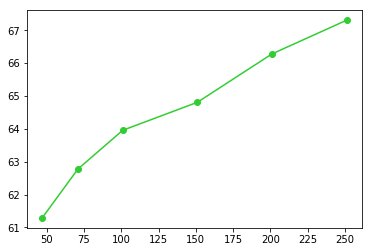

In [18]:
plt.plot(out_df['sr'], out_df['perc_err'], marker='o', color='limegreen')

In [19]:
# out_df = pd.read_csv('/home/pelto/oggm_runs/products_opt/Conrad/Conrad_DFB_errors.csv')

In [20]:
#small minimum function
x=0
for i in range(0,len(out_df['errors'])):
    if out_df['errors'][i]==np.min(out_df['errors']):
        x=i
print(glacier[num] + ' Minimal value is '+str(np.min(out_df['errors']))+ ' at SR' + ' = ' +str(np.round(out_df['sr'][x],decimals=2)))

Zillmer Minimal value is 826607.2190763424 at SR = 47.0
